# Reference Trajectory Notes
- For the heavy BC vehicle under consideration, when the entry flight path angle is an optimization variable, the altitude optimal (or velocity optimal) solution is essentially full lift up, typically with an extremely brief partial lift down at the very highest velocities. The issue of course is that this does not leave any margin for feedback - perturbed solutions can only ever undershoot the target. With SRP this is actually preferable in some sense, but choosing a better reference will bring all saturated solutions closer to the target. 

- Thus there is a very clear tradeoff to be made regarding nominal (and therefore mean) behavior vs robustness. 

- Lofting behavior is almost important. Unlike MSL-class vehicles which can be induced to loft long before parachute deployment conditions are met, the optimal strategy for a heavier vehicle may actually be to terminate the entry phase during lofting.


- With standard apollo, it is not obvious if a range trigger (which will occur at various velocities) is superior to a velocity trigger (which will have a much larger downrange spread but no velocity variation). And of course, we'll likely want to check

## Procedure for a given vehicle, target, etc 

- For a particular vehicle, namely ballistic coefficient and aerodynamic properties must be specified 
- For a given mission objective, design a reference trajectory and nominal ignition point. This can be done using optimal control, or other design techniques
- Use finite differencing to determine the gradient of the propellant cost to the ignition condition (required for feedback gain calculation)
- Create a table of SRP solutions based on an LHS design of some size around the nominal condition. The number of solutions should not be too large. 
- Compute the feedback gains for the terminal point controller 
- Run Monte Carlo to gauge performance, redesign reference and ignition as necessary 

# Terminal Point Control
A terminal point controller is one that seeks to drive the linear variation in a constraint $J(x)$ to zero despite small variations in state/parameters $\Delta x$ from the nominal $x_{ref}$.

Any such (first order) terminal point controller for a scalar control $u$, can be expressed in the form 
\begin{align}
u(t, x) = u(t,x_{ref}) + \Delta u \\
\Delta u =  -\frac{\Delta J}{\lambda_u} =-\frac{\lambda_x^T\Delta x}{\lambda_u}
\end{align}
where $\lambda_q(t) \triangleq \frac{\partial J(x(t_f))}{\partial x(t_f)}\frac{\partial x(t_f)}{\partial q(t)} $. This can also be written in terms of the first order state transtion matrix (STM)
\begin{align}
\lambda_x(t) = \frac{\partial J(x_f)}{\partial x_f}\Phi(t_f)\Phi^{-1}(t) \\
\Delta u =  \frac{\Delta x^T\left( \frac{\partial J}{\partial x}\Phi(t_f)\Phi^{-1}(t)\right)}{\lambda_u} 
\end{align}

Note the following general relationship between adjoint and forward sensitvity
\begin{align}
\lambda_x(t) &= \Phi(t_f)\Phi^{-1}(t) \\
\Phi(t) &= \lambda^{-1}(t)\lambda(t_0)
\end{align}


# Modified Entry Terminal Point Controller for Retropropulsion Based EDL

Standard Mars ETPC modulates the bank angle to achieve a target downrange at a fixed velocity by following a neighboring path:
\begin{align}
\delta S(V_f) = 0 
\end{align}
where $V_f$ is the desired parachute deployment velocity. 

The proposed modification links an optimal powered descent phase to the entry phase. Given a nominal entry profile, and a nominal ignition condition, the bank angle is modulated to eliminate the variation required fuel:
\begin{align}
\delta m(V_f) = 0 
\end{align}
where $V_f$ is the desired velocity at the end of the SRP deceleration phase.

The optimal solution to the SRP problem requires that the costates can be recovered. These provide the required sensitivity of the performance index to variation in the initial states. These are utilized as the terminal conditions and then integrated backward along the entry trajectory to determine the influence coefficients used in the feedback controller.

In essence, standard ETPC trades altitude and flight path angle to meet downrange at a terminal velocity. Our modified ETPC trades all 3 states to determine a neighboring ignition condition at the same velocity that requires approximately the same amount of fuel. Intuitively, this means that if the vehicle arrives at the ingition velocity with a steeper FPA, the downrange distance should be smaller and the altitude should be higher. 

Theoretically, our modification should provide superior performance even when triggered at a fixed velocity. However, it remains to be seen if it performs better with an adaptive trigger. We can compute the 2x2 matrix of ETPC version and trigger version to see if the modification works, or if the adaptive trigger is all we need. 

# Fuel Optimal EDL - Predictor Corrector

- Optimize a nominal profile, then fly it open loop down to the ground in a monte carlo simulation
- Determine the optimal ignition condition for each trajectory and record the optimal propellant required
- Determine the propellant required from other possible ignition conditions, particularly a fixed velocity or downrange distance (the nominal ones, likely)

This allows us to determine how much the adaptive trigger helps. Then we can perform another MC but with closed-loop fuel optimal guidance to determine how much the new entry guidance can influence the approach. Hopefully more than I believe is possible...

- Also compare against Apollo targeting downrange at fixed velocity. This gives a fairer comparison than the open loop version 

## Determining the optimal solution to the two-phase problem
- Solve the optimal entry with minimal velocity, subject to altitude constraint? 

If we assume the altitude constraint is given for e.g. safety reasons, then the optimal ignition will occur either at this altitude or somewhere before. By minimizing the velocity at that minimum altitude, there is only the possibility of suboptimality due to igniting at a slightly higher velocity but a more favoable FPA 

## Problem - Optimal Ignition Determination
Determining the optimal ignition condition is the slowest part because it requires solving an optimal control problem at every time step. For the open loop case, it's not quite as bad as we can use a bisection algorithm to find the optimal point. But the closed loop case will require a very quick algorithm - either something like the C-implemented GFOLD or else a table lookup of optimal solutions from any method. 

Question - how large does the table need to be?  Essentially we only need to guarantee we enter it at some point. We could use the open loop dispersions to determine the required bounding box, understanding that the closed loop case should be significantly smaller. There will naturally be regions where no solution exists.

Question - are entry trajectories monotonically decreasing in propellant consumption until some overshoot?

There is a strong interplay between range to go and horizontal velocity, and similarly altitude and vertical velocity. The gradient of propellant use wrt initial velocity will change sign for different ignition velocities relative to the downrange distance. 

### Lateral Guidance
Another concern is lateral guidance. Do we update the profile and fly the reversals as planned? Or do we plan the longitudinal and use a lateral corridor? Note that if we only use one parameter, we must use a separate lateral logic to handle reversals

In [963]:
import sys
sys.path.append("./EntryGuidance")
from scipy.interpolate import interp1d, LinearNDInterpolator, Rbf 
from scipy.integrate import odeint, cumtrapz 
from scipy.io import loadmat, savemat

from pyaudi import gdual_double, gdual_vdouble
import pyaudi as pa 
import numpy as np
import chaospy as cp 
# import seaborn
import matplotlib.pyplot as plt 

from Utils.boxgrid import boxgrid
import Utils.DA as da
from Utils.RK4 import RK4
from Utils.submatrix import submatrix 
from Utils.gpops import srp 

from EntryGuidance.EntryEquations import Entry, EDL
from EntryGuidance.Simulation import Simulation, Cycle, EntrySim
from EntryGuidance.InitialState import InitialState
from EntryGuidance.Planet import Planet 


In [20]:
def zcd(data): # Returns indices of zero crossings 
    sign_array=np.sign(data)
    out=[]
    current = sign_array[0]
    count=0
    for i in sign_array[1:]:
        if i!=current:
            out.append(count)
            current=i
            count=0
        else: count+=1
    return out

304 1-reversal, 310 2-reversal


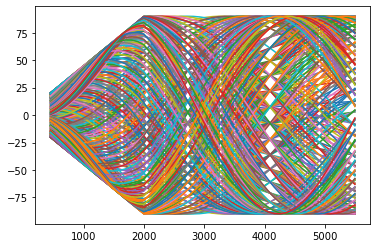

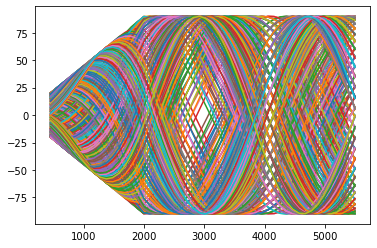

In [21]:
plt.close('all')
# Proposed parametrization 

def f(v, vshift): # vectorized version for plotting 
    out = v/vshift 
    out[v > vshift] = 1
    
    return out 

def profile_plot(Vs, shift, V0):
    return lambda V: np.cos(V*Vs + shift)*90 * f(V, V0)

# A constant parametrization is recovered with Vs = 0 

V = np.linspace(5500, 450)

# plt.figure(figsize=(10,10))
# for Vs in np.linspace(0, 0.005):
#     for bank_max in np.linspace(0, 90, 9):
#         plt.plot(V, profile(Vs,bank_max)(V), 'k', alpha=0.1)
        
        
# Look for two reversal families
# plt.figure(figsize=(10,10))
# V_reduce = 2000  # velocity magnitude at which to begin reducing bank magnitude 
# n1 = 0
# n2 = 0
# for Vs in np.linspace(0, 0.004, 100):
# #     for shift in np.linspace(0, 2*np.pi, 20):
#     for shift in np.linspace(0, 2*np.pi, 20):
#         bank = profile_plot(Vs, shift, V_reduce)(V)

#         zc = len(zcd(bank))

#         if zc == 2:
#             n2 += 1
#             plt.figure(2)
#             plt.plot(V, bank, alpha=1, label="Vs={:.5f}".format(Vs))
            
#         elif zc == 1:
#             n1 += 1
#             plt.figure(3)
#             plt.plot(V, bank, alpha=1, label="Vs={:.5f}".format(Vs))
        
# # plt.legend()
# # plt.figure(3)
# # plt.legend()
# print("{} 1-reversal, {} 2-reversal".format(n1, n2))
# plt.show()

In [ ]:
# To iniatialize, we should determine some approx optimal profiles for one and two reversals based on altitude at a terminal velocity and dr/crossrange 
# We could also solve the true OCP
# Then do nonlinear least squares to fit the parametrization to the solution 

In [ ]:
x0 = InitialState(vehicle='heavy')
print("m0 = {} kg".format(x0[-1]))
Vf = 525 

sim = Simulation(cycle=Cycle(1), output=False, use_da=False, **EntrySim(Vf=Vf), )

def f(v, vshift):
    if v > vshift:
        return 1
    else:
        return v/vshift
    
def profile(Vs, shift, V0):
    return lambda V: np.cos(V*Vs + shift)*np.pi/2 *f(V,V0)

V = np.linspace(x0[3], Vf)
Vr = 2000 

Xf = []
prof = []
for Vs in np.linspace(0.0, 0.005, 5):
    for shift in np.linspace(0, 2*np.pi, 36): 
        
#         bank = profile(Vs, shift)(V)
#         if zcd(bank): # has at least one reversal 
        prof.append((Vs, shift, Vr))
        ref_profile = lambda **d: profile(Vs, shift, Vr)(d['velocity'])
        res = sim.run(x0, [ref_profile])
        Xf.append(sim.x)
#         else:
#             continue
            
Xf = np.array(Xf)
prof = np.array(prof)

In [ ]:
r, th, ph, v, fpa, psi, s, m = Xf.T
h = sim.edlModel.altitude(Xf[:,0], km=True)
# plt.hist(h)

vs,shift,vr = prof.T
shift = np.degrees(shift)
# shift = shift < 180 # use this to create a dichotomy


plt.figure()
plt.subplot(211)
plt.scatter(v, h, c=shift)
plt.colorbar()

plt.subplot(212)
plt.scatter(v, h, c=vs)
plt.xlabel('Velocity (m/s)')
plt.ylabel('Altitude (km)')
plt.colorbar()


plt.figure()
plt.subplot(211)
plt.scatter(th*3396.2, -ph*3396.2, c=shift)
plt.colorbar()

plt.subplot(212)
plt.scatter(th*3396.2, -ph*3396.2, c=vs)
plt.colorbar()
plt.xlabel('DR (km)')
plt.ylabel('CR (km)')

# Plot just the "good" ones 
trim = h > -1
trim = np.logical_and(trim, np.abs(ph)*3396.2 < 1)

plt.figure()
plt.scatter(v[trim], h[trim])
plt.xlabel('Velocity (m/s)')
plt.ylabel('Altitude (km)')

plt.figure()
plt.scatter(th[trim]*3396.2, -ph[trim]*3396.2, c=h[trim])
plt.xlabel('DR (km)')
plt.ylabel('CR (km)')
plt.title('Color = Altitude')
plt.colorbar()

plt.figure()
plt.hist(vs[trim])
plt.show()

In [65]:
import pandas as pd 
data = np.concatenate([Xf, prof], axis=1)
cols = ['radius','longitude','latitude','velocity','fpa','azimuth','rtg','mass', 'scale','shift']
df = pd.DataFrame(data=data, columns=cols)
# df.to_csv("./data/profile30k.csv", index=False)

In [ ]:
# find the best profile so far 

cr = np.abs(ph)*3396.2
keep = cr <= 0.2
i = np.argmax(h[keep])
print("Max altitude at Vf with less than 200 m crossrange = {:.2f}".format(np.max(h[keep])))
opt = prof[keep][i]
print("From profile with Vs = {}, shift = {}".format(*opt))
x_opt = Xf[keep][i]
print(x_opt[1]*3396.2)
plt.plot(V, profile_plot(*opt)(V))
plt.show()

## Vectorized Monte Carlo to allow us to compare parametrizations and other guidance aspects rapidly 

In [909]:
class VMC(object):
    """ Monte carlo class """

    def __init__(self):

        self.samples    = None
        self.control    = None
        self.mc         = None


    def reference_data(self, ref_profile, Vf, plot=False):
        """ In closed loop simulations, generate reference data once and use it
            each simulation
        """
        print("Generating reference data...")
        from InitialState import InitialState

        x0 = InitialState()
        sim = Simulation(cycle=Cycle(0.2), output=False, **EntrySim(Vf=Vf))
        res = sim.run(x0, [ref_profile])
        self.ref_sim = sim

        if plot:
            sim.plot(compare=False)
            plt.show()
        # self.x0_nom = InitialState(1, bank=bank[0])
        print("...done. ")
        print(sim.history.shape)

    def sample(self, N, sample_type='S', parametric=True, initial=False, knowledge=False):
        """ Generates samples for use in Monte Carlo simulations """
        from Uncertainty import getUncertainty
        uncertainty = getUncertainty(parametric=parametric, initial=initial, knowledge=knowledge)

        self.samples = uncertainty['parametric'].sample(N, sample_type)
        self.psamples = uncertainty['parametric'].pdf(self.samples)
        print(" ")
        print("Generating {} samples...".format(N))

        str2name = {'S': 'Sobol', 'R': 'Random', 'L': 'Latin hypercube'}

        print("     {} sampling method".format(str2name[sample_type]))
        print("     Parametric uncertainty only")
        
    def null_sample(self, N,):
        """ Generates samples for use in Monte Carlo simulations """

        self.samples = np.zeros((4,N))
        print(" ")
        print("Generating {} samples...".format(N))


    def run(self, x0, stepsize=1, save=None):
        import time 
        if self.control is None:
            print(" ")
            print("Warning: The controls must be set prior to running.")
            print("Exiting.")
            return

        if self.samples is None:
            print(" ")
            print("Warning: The number and type of sampling must be set prior to running.")
            print("Exiting.")
            return


        print(" ")
        print("Running Monte Carlo...")
        t_start = time.time()
        self._run(x0, stepsize)
        print("Monte Carlo complete, time elapsed = {:.1f} s.".format(time.time()-t_start))

        if save is None:
            saveDir = './data/'
            filename = getFileName('MC_{}'.format(len(self.samples.T)), saveDir)
            fullfilename = saveDir + filename
            print("Saving {} to default location {}".format(filename, saveDir))
        elif save is False:
            return
        else:
            print("Saving data to user location {}".format(save))
            fullfilename = save

        savemat(fullfilename, {'xf': self.xf, 'states': self.mc, 'samples': self.samples, 'pdf': self.psamples})

    def _run(self, x, stepsize):
        
        edl = EDL(self.samples, Energy=True)
        
        self.model = edl
        optSize = self.samples.shape[1]
        if x.ndim == 1:  # Allows a single initial condition or an array
            x = np.tile(x, (optSize, 1)).T
        X = [x]
        energy = np.mean(edl.energy(x[0], x[3], False))
        print("E0 {:.1f}".format(energy))
        energyf = edl.energy(edl.planet.radius, 250, False)  # go down to low energy then parse afterward
        print("Ef {:.1f}".format(energyf))

        U = []
        E = [energy]
        while True:
            # print("E: {:.1f}".format(energy))
            Xc = X[-1]
            energys = edl.energy(Xc[0], Xc[3], False)
#             emax = np.max(energys)
#             emin = np.min(energys)
#             print("Ediff = {}".format(emax-emin))
            lift, drag = edl.aeroforces(Xc[0], Xc[3], Xc[6])

            # Range control
            u = self.control(energys, Xc, lift, drag)
            U.append(u)

            # Shape the control
            u.shape = (1, optSize)
            u = np.vstack((u, np.zeros((2, optSize))))
            de = -np.mean(drag)*np.mean(Xc[3]) * stepsize
            # if (energy + de) < energyf:
            #     de = energyf - energy
            eom = edl.dynamics(u)
            X.append(RK4(eom, X[-1], np.linspace(energy, energy+de, 10))[-1])
            energy += de
            E.append(energy)

            if np.isnan(energy):
                print("Something wrong")
                break

            if energy <= energyf:
                print("energy depleted ")
                break 

            if len(E) > 6000:
                print("Breaking ")
                break
        X = np.array(X)
        U = np.array(U)
        print("MC shape")
        print(X.shape)
        print(U.shape)
        self.mc_full = X
        self.mc_control = U 
        self.trigger()  
        # This will provide flexibility to use different triggers 

    def set_trigger(self, trigger_function):
        self._trigger = trigger_function 

    def trigger(self):
        xfi = [self._trigger(traj) for traj in np.transpose(self.mc_full, (2,0,1))] # the true stopping point is between this and xfi-1
        xf = [traj[i] for i, traj in zip(xfi, np.transpose(self.mc_full, (2,0,1)))], 
        self.xf = np.array(xf).squeeze()
        print("Terminal state shape: ")
        print(np.shape(self.xf))
        self.mc = [traj[:i] for i, traj in zip(xfi, np.transpose(self.mc_full, (2,0,1)))]
        self.mcu = [traj[:i] for i, traj in zip(xfi, np.transpose(self.mc_control, (2,0,1)))]
        
    def plot_trajectories(self, figsize=(10, 6)):
        
        plt.figure(10, figsize=figsize)

        for X,U in zip(self.mc,self.mcu): # each is n_samples x n_points now
            r,lon,lat,v,fpa,psi,m = X.T
            dr = self.model.planet.radius*lon/1000
            cr = -self.model.planet.radius*lat/1000
            h = self.model.altitude(r, km=True)
            plt.figure(10)
            plt.plot(v, h )
            plt.xlabel('Velocity ')

            plt.figure(11, figsize=figsize)
            plt.plot(cr, dr)
            
            plt.figure(12, figsize=figsize)
            plt.plot(v, np.degrees(U))
            plt.xlabel('Velocity ')

    def plot(self, figsize=(10, 6), fontsize=16):
        try:
            self.mc 
            self.xf 
        except AttributeError:
            if hasattr(self, 'mc_full'):
                print("MonteCarlo has been run but trigger has not been called to determine final states.")
            else:
                print("MonteCarlo must be run before plotting.")
            return 



        r,lon,lat,v,fpa,psi,m = self.xf.T
    
        h = (r-self.model.planet.radius)/1000
        dr = self.model.planet.radius*lon/1000
        cr = -self.model.planet.radius*lat/1000
        
        plt.figure(3)
        plt.plot(v, h,'o')
        plt.xlabel('Velocity ')
        plt.ylabel('Altitude ')
        plt.figure(4)
        plt.scatter(cr, dr, c=h)
        plt.xlabel('Crossrange')
        plt.ylabel('Downrange')

        plt.title("Colored by Altitude")
        plt.colorbar()
        
        try:
            xf = self.ref_sim.history[-1]
            hor_err = np.sqrt((lon - xf[1])**2 + xf[2]**2)*3397
            
            plt.figure(5, figsize=figsize)
            plt.hist(hor_err, cumulative=True, histtype='step', bins='auto', linewidth=4, density=True)
            plt.xlabel("Horizontal Error (km)")
        except AttributeError:  # No ref sim, perhaps because loaded from file, or because no reference is needed 
            pass 

        # plt.figure(6, figsize=figsize)
        # plt.hist((r-self.model.planet.radius)/1000., cumulative=True, histtype='step', bins='auto', linewidth=4, density=True)
        # plt.xlabel("Final Altitude (km)")

    def load(self, mat_file):
        data = loadmat(mat_file)
        print(data['states'].shape)
        try:
            self.xf = data['xf']
        except KeyError:
            self.xf = data['states'][-1]

        self.mc = np.transpose(data['states'], (0,2,1))
        self.samples = data['samples']
        self.psamples = data['pdf']
        edl = EDL(self.samples, Energy=True)
        self.model = edl


def getFileName(name, save_dir):
    """
        Looks in 'save_dir' for files with the pattern name-date-number

        I.e. if name = 'MC' and dir/MC-date-1 exists, MC-date-2 will be returned.
    """
    date = datetime.now().date()

    files = os.listdir(save_dir)
    current = 1
    fname = "{}_{}_{}.mat".format(name, date, current)
    while fname in files:
        current += 1
        fname = "{}_{}_{}.mat".format(name, date, current)

    return fname

def velocity_trigger(Vf=550):
    
    def _trigger(traj):
        for idx, state in enumerate(traj):
            if state[3] <= Vf:  
                return idx
        return -1
    return _trigger 

def altitude_trigger(h=4):
    
    def _trigger(traj):
        for idx,state in enumerate(traj):
            if (state[0]-3397000)/1000. <= h:
                return idx
        return -1
    return _trigger
            

In [1001]:
def srp_from_entry(entry_state, rtg, cr):
    """ Utility to convert entry state to the cartesian coordinates needed"""
    if len(entry_state) == 7:
        r,th,ph,v,fpa,psi,m = entry_state
    else:
        r,th,ph,v,fpa,psi,m = entry_state.T
    heading = np.arctan2(cr, rtg)

    x_srp = np.array([rtg,
    cr,
    r-3397e3,
    v*np.cos(fpa)*np.cos(psi-heading),
    v*np.cos(fpa)*np.sin(psi-heading),
    v*np.sin(fpa)])
    return x_srp

def range_from_entry(entry_state, target):
    if len(entry_state) == 7:
        r,th,ph,v,fpa,psi,m = entry_state
    else:
        r,th,ph,v,fpa,psi,m = entry_state.T
        
    planet = Planet('Mars')
    rtogo, crossrange = planet.range(th, ph, psi, *target, km=False)
    return rtogo, crossrange 

In [ ]:
def constant_controller(banks):
    def _control(e,x,l,d):
        return banks
    return _control

class MCController:
    
    """ From current state, integrate a profile forward in a vectorized manner, 
    select the best one -  requires both determining the best/correct endpoint of a given trajectory, 
    as well as the best trajectories from the set and interpolating 
    
    Given that we will have a target altitude at the end of the deceleration phase (site altitude + margin)
    An altitude trigger set to that altitude makes sense, as the ignition point is guaranteed to be earlier 
    
    """
    
    def __init__(self, N):
        self.vmc = VMC()
        self.vmc.null_sample(N)
        self.vmc.control = constant_controller(np.linspace(-np.pi/2, np.pi/2, N))

#         mc.set_trigger(velocity_trigger(Vf))
        self.vmc.set_trigger(altitude_trigger(0)) # 4.6 km is the optimal altitude at 500 m/s with efpa -20.8. The final velocity is basically a measure of the suboptimality wrt fuel consumption 

        

    def __call__(self, current_state, **kwargs):
        
        self.vmc.run(current_state, save=False, stepsize=1)
        self.vmc.plot()
        
x0 = InitialState(vehicle='heavy', fpa=np.radians(-20.8))       
mcc = MCController(31)
mcc(x0)

## Vectorized Apollo Implementation

In [624]:
def predict_error(IV, D, r_dot, rtogo, V, ref):
#     print(IV)
#     print("V = {}".format(V))
#     print("Drag accel = {}, ref = {}".format(D, ref['DREF'](IV)))
#     print("Alt Rate: {} m/s, ref = {} m/s".format(r_dot, ref['RTOGO'](IV)))
#     print("RTG: {}, ref = {} \n".format(rtogo, ref['RTOGO'](IV)))
    return ref['F1'](IV)*(D-ref['DREF'](IV)) + ref['F2'](IV)*(r_dot-ref['RDTREF'](IV)) + ref['F4'](IV)*(rtogo - ref['RTOGO'](IV)) + ref['F5'](IV)*(V - ref['VREF'](IV))

def LoD_command(IV, error, ref):
    du = ref['F3'](IV)
    du[du == 0] = 1 
    return ref['LOD'](IV) + ref['K']*error/du
    
def bank_command(LoD, LoD_com, minimum=0, maximum=1):
    return np.arccos(np.clip(LoD_com/LoD,minimum,maximum))

def controller(target, reference, use_energy=False, one_sided=False, debug=False, bank_lims=[0,90]):
    """ Vectorized Apollo Implementation 

    Reference is a dictionary with reference states, influence coefficients, overcontrol gain, and planet model, required for computing distances to the target 
    Target is the lon/lat in radians 
    Use_energy is a flag; velocity will be used if False 


    """
    def _controller(energy, state, lift, drag):

        r, lon, lat, v, fpa, azimuth, mass =  state
        if use_energy:
            iv = energy
        else:
            iv = v 
            
        rdot = v*np.sin(fpa)
        rtogo, crossrange = reference['planet'].range(lon, lat, azimuth, *target, km=False)
        error = predict_error(iv, drag, rdot, rtogo, v, reference)
#         if np.any(np.isnan(error)):
#             error[np.isnan(error)] = 0
        error[drag<0.2] = 0 # open loop reference till drag condition is met 
        if one_sided == 1:  # keep positive errors 
            error[error<=0] = 0
            
        if one_sided == -1:
            error[error>=0] = 0 # keep negative errors only 
                
        LoDc = LoD_command(iv, error, reference)
        sign = np.sign(reference['U'](iv))
        sign[sign==0] = 1
        sigma = np.clip(bank_command(lift/drag, LoDc), *np.radians(bank_lims))*sign
        if debug:
            print("DR = {}, CR = {} km".format(rtogo/1000, crossrange/1000))
            print("Predicted Error = {}".format(error/1000))
            print("Bank Cmd = {} deg".format(np.degrees(sigma)))
            print("Nan Control, States= {}".format(state.T[np.isnan(sigma)]))
        
        
        return sigma 
    _controller.error_history = []
    return _controller
    
    
def open_loop(reference, use_energy=False):
    def _controller(energy, state, lift, drag):

        r, lon, lat, v, fpa, azimuth, mass =  state
        if use_energy:
            iv = energy
        else:
            iv = v 
        
        LoDc = reference['LOD'](iv)
        sigma = bank_command(lift/drag, LoDc) * np.sign(reference['U'](iv))
        
        return sigma 
    return _controller

In [625]:
def gains(traj, L0, edlModel, use_energy=False, use_drag_rate=False):
    """ Determines the sensitivities based on a reference trajectory 
    
        traj should be a dataframe or array from sim output 
        L0 is the initial condition for the adjoints at the terminal state
        L0 order is [s, v, gamma, h, u]
    
    """ 
    edl = edlModel   
    w = edl.planet.omega
    
#     traj = sim.output
    time = traj[:,0]
    energy = traj[:,1]
    bank = np.radians(traj[:,2])
    radius = traj[:,4]
    lon = np.radians(traj[:,5])
    lat = np.radians(traj[:,6])
    vel = traj[:,7]
    fpa = np.radians(traj[:,8])
    azi = np.radians(traj[:,9])
    rtgo = traj[-1,10]-traj[:,10]
    lift = traj[:,12]
    drag = traj[:,13]
    
    lod = lift*np.cos(bank)/drag
    altrate = vel*np.sin(fpa)
    
    # Prep for backwards integration of adjoints
#     l1 = 1.0                  # s
#     l2 = 0.0                  # v
#     l3 = 0.0                  # gamma
#     # l3 = (radius[-1]-edl.planet.radius)*sin(fpa[-1])**2     # gamma
#     l4 = -1.0/tan(fpa[-1])    # h
#     l5 = 0.0                  # u
    
    l1,l2,l3,l4,l5 = L0 
    L = [[l1,l2,l3,l4,l5]]
    
    hs = edl.planet.scaleHeight
    akm = 1000.0

    tfine = np.linspace(time[-1], time[0], 10000) # backwards
    dt = tfine[-2]
    rtogo = interp1d(time, rtgo*1000)(tfine) 
    vref  = interp1d(time, vel)(tfine)
    eref  = interp1d(time, energy)(tfine)
    rref  = interp1d(time, radius)(tfine)
    rdtref = interp1d(time, altrate)(tfine)
    dref = interp1d(time, drag)(tfine)
    ddtref = np.diff(dref)/np.diff(tfine)
    lodref = interp1d(time, lod)(tfine)
    gamma = interp1d(time, fpa)(tfine)

    g = edl.gravity(rref)

    liftv = lodref*dref
    sg = np.sin(gamma)
    cg = np.cos(gamma)
    c1 = liftv/vref**2 + cg/rref + g*cg/vref**2
    c2 = (vref/rref - g/vref)*sg
    f1 = []
    f2 = []
    f3 = []
    f4 = []
    f5 = []
    iv = np.argmax(vref)
    uref = interp1d(time, bank)(tfine)[:iv]
    
    for i in range(tfine.shape[0]):
        
        f1.append(-hs/dref[i]*l4) 
        if use_drag_rate:
            f2.append(l3/(-cg[i]*dref[i]*(vref[i]/hs + 2*g/vref[i])))
        else:
            f2.append(l3/(vref[i]*cg[i]))
        f3.append(l5)
        f4.append(l1)
        f5.append(l2)
        
        
        # Leave these for posterity 
#         dl1 = 0
#         dl2 = -cg[i]*l1 + 2*dref[i]/vref[i]*l2 - c1[i]*l3 - sg[i]*l4                        
#         dl3 = vref[i]*sg[i]*l1 + g[i]*cg[i]*l2 + c2[i]*l3 - vref[i]*cg[i]*l4
#         dl4 = -dref[i]/hs*l2 + l3*(liftv[i]/vref[i]/hs + vref[i]*cg[i]/rref[i]**2) # original 
#         dl4 = (-dref[i]/hs - 2*g[i]/rref[i])*l2 + l3*(liftv[i]/vref[i]/hs + vref[i]*cg[i]/rref[i]**2 - cg[i]*2*g[i]/rref[i]/vref[i])  # my mod 
#         dl5 = -dref[i]/vref[i]*l3
        
        # Try to find a sign error?
        dl1 = 0
        dl2 =        -cg[i]*l1 + 2*dref[i]/vref[i]*l2 - c1[i]*l3 - sg[i]*l4                        
        dl3 = vref[i]*sg[i]*l1 +        g[i]*cg[i]*l2 + c2[i]*l3 - vref[i]*cg[i]*l4
        dl4 =                          -dref[i]/hs*l2 +       l3*(liftv[i]/vref[i]/hs + vref[i]*cg[i]/rref[i]**2) 
        dl5 =                                -dref[i]/vref[i]*l3
    
        l1 -= dt*dl1
        l2 -= dt*dl2
        l3 -= dt*dl3
        l4 -= dt*dl4
        l5 -= dt*dl5
        L.append([l1, l2, l3, l4, l5])  # This is just to keep them for plotting

    # build the output dictionary
    if use_energy:
        vi = eref[0:iv]
    else:
        vi = vref[0:iv]

    f1 = np.array(f1)[:iv]
    f2 = np.array(f2)[:iv]
    f4 = np.array(f4)[:iv]
    f5 = np.array(f5)[:iv]
    f3 = np.array(f3)[:iv]
    
    nzi = f3.nonzero()   

    data = { 'F1'     : interp1d(vi, f1,          fill_value=(f1[0], f1[-1]),         assume_sorted=True, bounds_error=False),  # Drag gain 
             'F2'     : interp1d(vi, f2,          fill_value=(f2[0], f2[-1]),         assume_sorted=True, bounds_error=False),  # Altitude rate (or drag rate) gain
             'F3'     : interp1d(vi[nzi], f3[nzi],     fill_value=(f3[0], f3[-1]),         assume_sorted=True, bounds_error=False),  # Control gain
             'F4'     : interp1d(vi, f4[:iv],     fill_value=(f4[0], f4[-1]),         assume_sorted=True, bounds_error=False),  # Range gain    
             'F5'     : interp1d(vi, f5[:iv],     fill_value=(f5[0], f5[-1]),         assume_sorted=True, bounds_error=False),  # Velocity gain

             'RTOGO'  : interp1d(vi, rtogo[:iv],  fill_value=(rtogo[0], rtogo[iv]),   assume_sorted=True, bounds_error=False),
             'RDTREF' : interp1d(vi, rdtref[:iv], fill_value=(rdtref[0], rdtref[iv]), assume_sorted=True, bounds_error=False),
             'DREF'   : interp1d(vi, dref[:iv],   fill_value=(dref[0], dref[iv]),     assume_sorted=True, bounds_error=False),
             'VREF'   : interp1d(vi, vref[:iv],   fill_value=(vref[0], vref[iv]),     assume_sorted=True, bounds_error=False),
             'DDTREF' : interp1d(vi, ddtref[:iv], fill_value=(ddtref[0], ddtref[iv]), assume_sorted=True, bounds_error=False),
             'LOD'    : interp1d(vi, lodref[:iv], fill_value=(lodref[0], lodref[iv]), assume_sorted=True, bounds_error=False),
             'U'      : interp1d(vi, uref,        fill_value=(uref[0], uref[-1]),     assume_sorted=True, bounds_error=False),
             'K'      : 1,
             'L'      : np.array(L[:iv]),  # These last two are not used by the controller 
             'IV'     : vi,
            'use_energy': use_energy,
            }
             
    return data

## Entry Profile Parametrization

In [574]:
# Create a vectorized controller 

def f_vector(v, vshift):
    out = v/vshift 
    out[v > vshift] = 1
    
    return out 

def profile(Vs, shift, V0):
    return lambda E,X,L,D: np.cos(X[3]*Vs + shift)*np.pi/2 * f_vector(X[3],V0)

x0 = InitialState(vehicle='heavy', fpa=np.radians(-20.8))
Vf = 500

V = np.linspace(x0[3], Vf)
param = []
for Vs in np.linspace(0.0, 0.005, 100):
# for Vs in [0]:
    for Vr in [ 2500,]:
        for shift in np.linspace(0, 2*np.pi, 37): 
            param.append((Vs, shift, Vr))
        
param = np.array(param)
print(np.shape(param))

(3700, 3)


In [575]:
def fixed_controller(bank, v_reverse):
    """ This version requires v_reverse to be the same length as the state
    This is so that we can quickly determine where a reversal should go 
    
    """
    def _control(e,x,l,d):
        sigma = np.ones_like(x[0])*bank
        sigma[np.less_equal(x[3], v_reverse)] *= -1 
        return sigma
    return _control

def reversal_controller(bank, v_reverse):
    """ This version requires v_reverse to be scalar
    This is for generating a reference trajectory 
    
    """
    def _control(v):
        sigma = bank
        if v < v_reverse:
            sigma = -bank 
        return sigma
    return _control

In [ ]:
N = param.shape[0]
N = 10
mc = VMC()
mc.sample(N)
mc.samples *= 0

# mc.control = profile(*param.T)
banks = [5, 15, 25, 45, 65, 80]
reverse = [2815, 2865, 2962, 3215., 3455., 3608.]
rev = interp1d(banks, reverse)

Vr = np.linspace(3600, 3610, N)
sigma = 35
mc.control = fixed_controller(np.radians(sigma), Vr)
mc.set_trigger(velocity_trigger(Vf))
# mc.set_trigger(altitude_trigger(4.6)) # 4.6 km is the optimal altitude at 500 m/s with efpa -20.8. The final velocity is basically a measure of the suboptimality wrt fuel consumption 

mc.run(x0, save=False, stepsize=0.05)

In [ ]:
plt.plot(Vr, -mc.xf[:,2]*3397)

In [ ]:
mc.plot()
plt.show()

In [ ]:
banks = [5, 15, 25, 45, 65, 80]
reverse = [2815, 2865, 2962, 3215., 3455., 3608.]
plt.plot(banks, reverse, 'o-')
plt.xlabel("Constant Bank Angle (deg)")
plt.ylabel("Reversal Vel to Achieve 0 Crossrange")
plt.show()

rev = interp1d(banks, reverse)

In [384]:
rev(16)

array(2874.7)

Max altitude at Vf = 497.9 m/s with less than 200 m crossrange = 4.31
From profile with Vs = 0.00010101010101010101, shift = 1.222673897613325, Vr = 2500.0
DR = 550.6 km


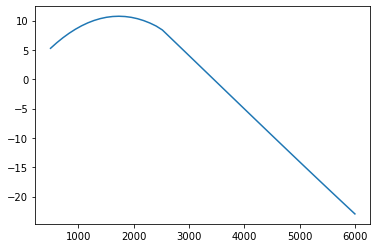

In [77]:
r,lon,lat,v,fpa,psi,m = mc.xf.T

h = (r-mc.model.planet.radius)/1000
dr = mc.model.planet.radius*lon/1000
cr = -mc.model.planet.radius*lat/1000

keep = np.abs(cr) <= 0.2
i = np.argmax(h[keep])
print("Max altitude at Vf = {:.1f} m/s with less than 200 m crossrange = {:.2f}".format(v[keep][i],np.max(h[keep])))
opt = param[keep][i]
print("From profile with Vs = {}, shift = {}, Vr = {}".format(*opt))
print("DR = {:.1f} km".format(dr[keep][i]))
plt.plot(V, profile_plot(*opt)(V))
plt.show()

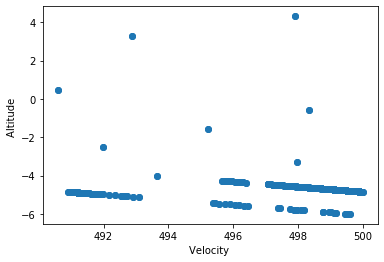

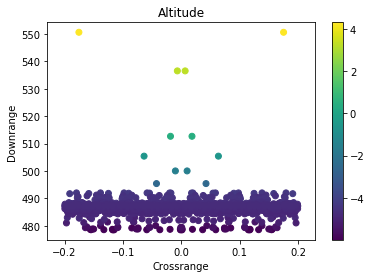

In [78]:
plt.figure(3)
plt.plot(v[keep], h[keep],'o')
plt.xlabel('Velocity ')
plt.ylabel('Altitude ')

plt.figure(4)
plt.scatter(cr[keep], dr[keep], c=h[keep])
plt.xlabel('Crossrange')
plt.ylabel('Downrange')

plt.title("Altitude")
plt.colorbar()
plt.show()

## Determine Adjoints for different objectives 

In [657]:
x0 = InitialState(vehicle='heavy', fpa=np.radians(-20.8))

Vf = 500 
dasim = Simulation(cycle=Cycle(1), output=False, use_da=True, **EntrySim(Vf=Vf), )

names = ['r', 'theta', 'phi', 'V', 'fpa', 'psi', 'm']
x0d = da.make(x0, names, 2)
u = gdual_double(0., 'u', 2)
# ref_profile = lambda **args: u

def ref_profile(velocity, **args):
    sigma = reversal_controller(np.radians(35), rev(35))(da.const(velocity))
    sigma = sigma + np.sign(sigma)*u
    return sigma 


res = dasim.run(x0d, [ref_profile])
traj = da.const(dasim.df.values, True)

In [658]:
# get stms for longitudinal states 
rows = [1, 3, 4, 0]
cols = rows + [-1] # get the derivs wrt controls too 
stm = [np.vstack([submatrix(da.jacobian(x, names+['u']), rows, cols), np.eye(5)[-1]]) for x in dasim.history]

# get adjoints 

dJdx = [dasim.edlModel.planet.radius, 0, 0, -1.0/np.tan(dasim.history[-1, 4].constant_cf), 0] # The apollo adjoints 
# dJdx = [dasim.edlModel.planet.radius, 0, 0, 0, 0] # The sensitivity to range alone  
dJdx = [0, 0, 0, 1, 0] # The sensitivity to altitude alone  
# dmdx = [-0.1*dasim.edlModel.planet.radius, 0.11, -760, -0.18, 0] # x = [s,v,fpa,h,u] for a nominal ignition at 500 m/s, -10 deg fpa, 5k downrange and 3 km altitude 
# dJdx = dmdx

stmi = [np.linalg.inv(st) for st in stm]
stmf = stm[-1]
C = np.dot(dJdx, stmf)
L = np.array([np.dot(C, si) for si in stmi])
sigma = da.const(dasim.control_history, True).T[0]
LoD = traj[:,12]/traj[:,13]
L[:,-1] *= -1/LoD/np.abs(np.sin(sigma))  # This converts from sensitivity in sigma to sensitivity of u = L/D cos(sigma)
L[:,0] /= dasim.edlModel.planet.radius # This converts from sensitivity in theta to sensitivity in range 

In [659]:
dasim.history[-1, 4].constant_cf * 180/np.pi

-3.464105130407081

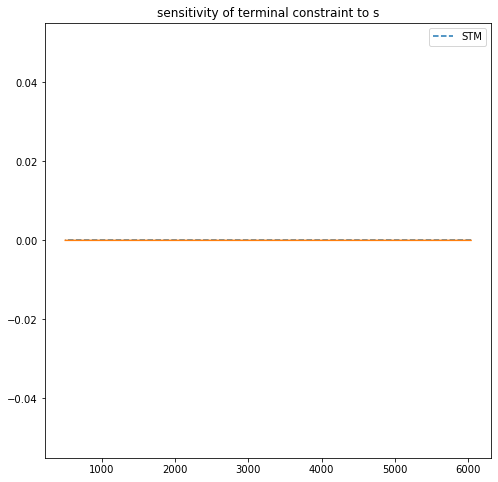

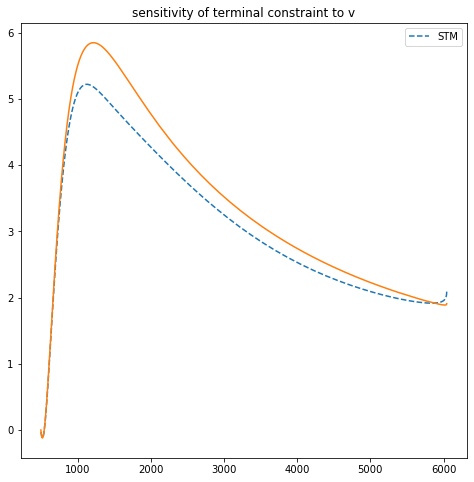

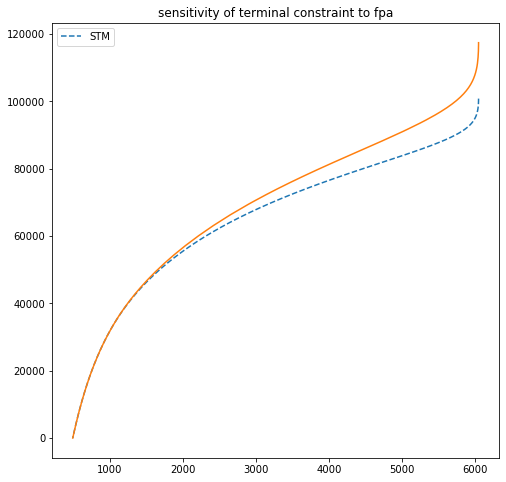

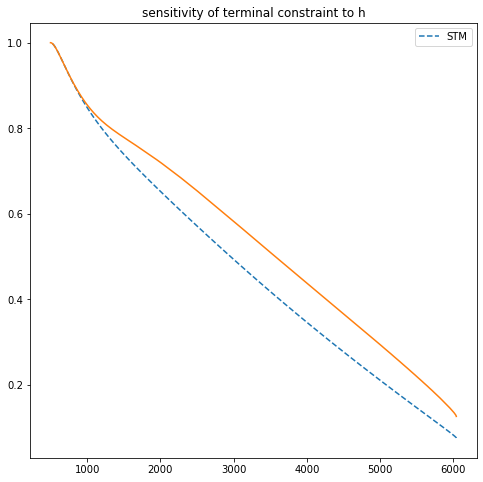

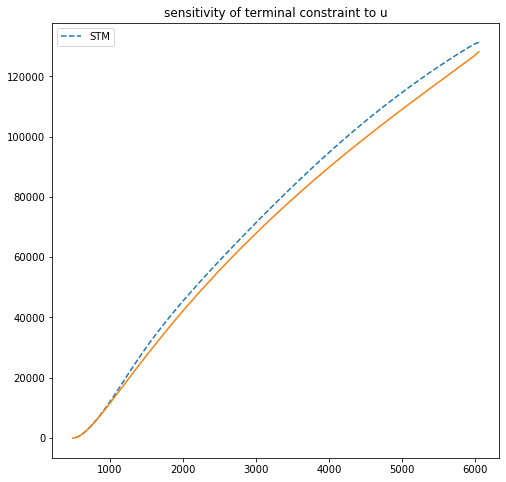

In [660]:
traj = da.const(dasim.df.values, True)

# s v gamma h u 
# L0 = [-np.tan(dasim.history[-1, 4].constant_cf), 0, 0, 1, 0] # altitude with free tf, produces results identical to the apollo method despite different gains!! 
# L0 = [np.tan(dasim.history[-1, 4].constant_cf), 0, 0, 1, 0]
# L0 = [-0.1, 0.5, -250, -0.18, 0] # mass
# L0 =  [1, 0, 0, -1.0/np.tan(dasim.history[-1, 4].constant_cf), 0] # apollo downrange with free tf 
L0 =  [0, 0, 0, 1, 0]

apollo = gains(traj, L0, dasim.edlModel, use_energy=False, use_drag_rate=False)

# plot the adjoints from each method 
V = da.const(dasim.history[:, 3])
imax = np.argmax(V)
nams = ['s','v','fpa', 'h', 'u']
for name, adj_stm, adjoint in zip(nams, L.T, apollo['L'].T):
    plt.figure(figsize=(8, 8))
    plt.plot(V[imax:], adj_stm[imax:], '--',label='STM')
    plt.plot(apollo['IV'], adjoint)

    plt.title("sensitivity of terminal constraint to {}".format(name))
    plt.legend()
plt.show()



## Standard ETPC Monte Carlo

- Run nominal sim to fairly low velocity
- Determine ignition condition, optimal or otherwise 
- Create the apollo gains from the ignition condition
- Vectorized MC to past the nominal downrange/velocity
- Compute SRP cost from both the nominal downrange/velocity (if feasible) and from the optimal point along the trajectory 

In [995]:
N = 500

mc = VMC()

mc.sample(N)

lon = np.radians(traj[-1,5])
lat = np.radians(traj[-1,6])
target = (lon, lat)
apollo['K'] = 1
apollo['planet'] = dasim.edlModel.planet
print("Target = {}".format(target))
print("DR = {:.1f}, CR = {:.2f}".format(*dasim.edlModel.planet.range(np.radians(traj[0,5]), np.radians(traj[0,6]), np.radians(traj[0,9]),*target, km=True)))

mc.control = controller(target, apollo, use_energy=apollo['use_energy'], debug=False, one_sided=0, bank_lims=[0,85])
# mc.control = open_loop(apollo)

mc.set_trigger(velocity_trigger(Vf))
# mc.set_trigger(altitude_trigger(4.6)) # 4.6 km is the optimal altitude at 500 m/s with efpa -20.8. The final velocity is basically a measure of the suboptimality wrt fuel consumption 

mc.run(x0, save=False, stepsize=1)

 
Generating 500 samples...
     Sobol sampling method
     Parametric uncertainty only
Target = (0.15211933788702403, -4.675565924233114e-05)
DR = 516.7, CR = 0.16
 
Running Monte Carlo...
E0 18509313.6
Ef 31250.0
energy depleted 
MC shape
(221, 7, 500)
(220, 1, 500)
Terminal state shape: 
(500, 7)
Monte Carlo complete, time elapsed = 5.1 s.


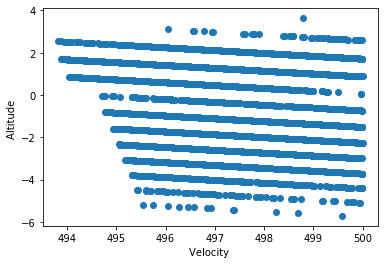

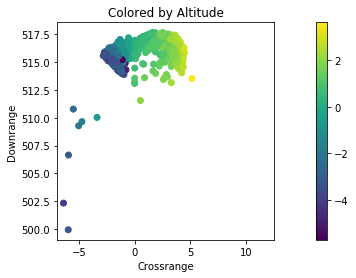

In [641]:
mc.plot()
plt.axis('square')
if N <= 500:
    mc.plot_trajectories()

In [642]:
m = np.mean(mc.xf, axis=0)
s = np.std(mc.xf, axis=0)

h = mc.model.altitude(m[0],km=True)
dr,cr = mc.model.planet.range(np.radians(traj[0,5]), np.radians(traj[0,6]), np.radians(traj[0,9]), *m[1:3], km=True)

print("- Mean altitude = {:.2f} +/- {:.2f} km (3-sigma)".format(h, 3*s[0]/1000))
print("- Mean DR       = {:.1f} +/- {:.2f} km (3-sigma)".format(dr, 3*s[1]*mc.model.planet.radius/1000))
print("- Mean CR       = {:.3f} +/- {:.2f} km (3-sigma)".format(cr, 3*s[2]*mc.model.planet.radius/1000))

- Mean altitude = -0.70 +/- 6.06 km (3-sigma)
- Mean DR       = 516.0 +/- 2.77 km (3-sigma)
- Mean CR       = 0.123 +/- 5.81 km (3-sigma)


Open Loop
- Mean altitude = 0.09 +/- 1.60 km (3-sigma)
- Mean DR       = 516.6 +/- 6.17 km (3-sigma)
- Mean CR       = -0.367 +/- 0.26 km (3-sigma)

With geometric considerations for altitude target with positive sign in front of tangent term


Energy version


With pure altitude target 


With usual apollo target, or with altitude target with neg sign in front of tangent term 
- Mean altitude = -0.78 +/- 6.37 km (3-sigma)
- Mean DR       = 515.8 +/- 3.23 km (3-sigma)
- Mean CR       = 0.312 +/- 5.91 km (3-sigma)

K = 0.5
- Mean altitude = -0.14 +/- 3.47 km (3-sigma)
- Mean DR       = 516.4 +/- 3.77 km (3-sigma)
- Mean CR       = -0.188 +/- 2.69 km (3-sigma)


Usual Apollo but with energy 
- Mean altitude = -0.87 +/- 6.66 km (3-sigma)
- Mean DR       = 515.5 +/- 3.69 km (3-sigma)
- Mean CR       = 0.033 +/- 6.28 km (3-sigma)

<!-- With mass target, for which we should not expect fixed DR/altitude etc -->


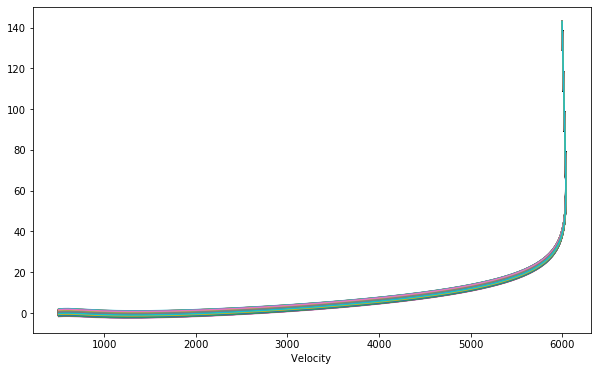

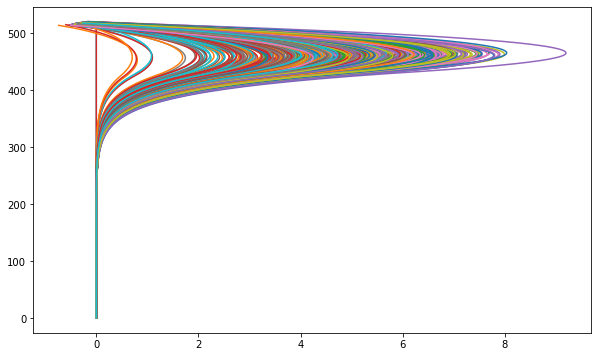

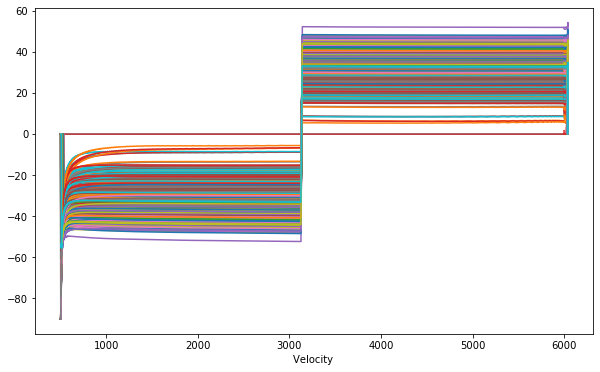

In [446]:
mc.plot_trajectories()

In [1020]:
target = (lon + 5/3397, lat)

rtg,cr = range_from_entry(mc.mc[0], target)
x_srp = srp_from_entry(mc.mc[0], rtg, cr)
# m_srp = srpdata(x_srp)

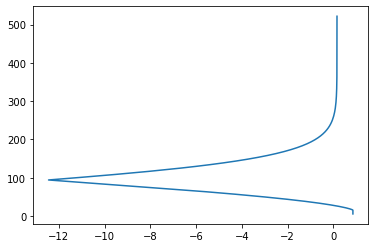

In [1021]:
plt.plot(cr/1000, rtg/1000)

Text(0, 0.5, 'Propellant Used (kg)')

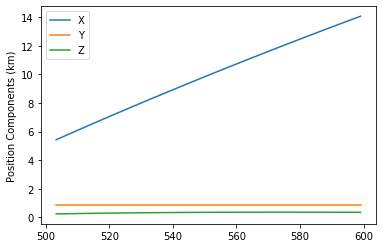

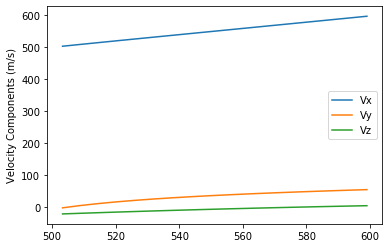

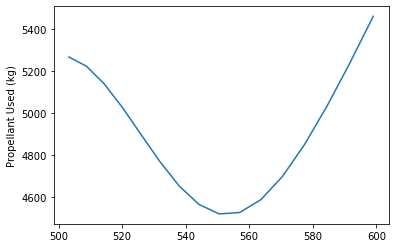

In [1022]:
v = mc.mc[0][:,3]
k = v < 600
plt.figure()
plt.plot(v[k], x_srp[:3, k].T/1000)
plt.legend(['X','Y','Z'])
plt.ylabel("Position Components (km)")

plt.figure()
plt.plot(v[k], x_srp[3:, k].T)
plt.legend(['Vx','Vy','Vz'])

plt.ylabel("Velocity Components (m/s)")

m_srp = srpdata(x_srp[:,k])
plt.figure()
plt.plot(v[k], m_srp)

plt.ylabel("Propellant Used (kg)")

## SRP Table Creation

In [984]:
class SRPData:
    
    def __init__(self, file):
        self.fname = file
        self.data = loadmat(file)
#         self.model = None
#         try:
#             self.build()
#         except MemoryError:
#             self.build(N=10000)
        self.build(5000)
    

            
    def build(self, N=0):
        """ model options are [rbf, linear, nearest]
        N is the number of samples to use, only required if the model is too big with full sample size"""
        
        from time import time 
        
        input_data = self.data['initial'].T
        input_data = input_data[:-1] # drop the mass column 
        output_data = self.data['fuel'].squeeze()
        
        if N:
            input_data = input_data[:,:N]
            output_data = output_data[:N]
            
        self.bounds = np.array([np.min(input_data, axis=1), np.max(input_data, axis=1)])
        
        print("Building SRP propellant model from data...")
        print("    bounds = {}".format(self.bounds.T))
        t0 = time()
        self.model = Rbf(*input_data, output_data)
        print("Complete: {:.1f} s".format(time()-t0))
#         self.model = LinearNDInterpolator(input_data.T, output_data, rescale=True)
        
    def check_bounds(self, state):
        pass 
    
    def __call__(self, state):
        """ State should be the 6 dimensional SRP ignition state"""
        try:
            return self.model(*np.asarray(state).T)
        except ValueError:
            return self.model(*np.asarray(state))
#         return self.model(state) # For a linear model 

        


In [985]:
srpdata = SRPData("E:\Documents\GitHub\Research\Matlab\srp_47254.mat")

Building SRP propellant model from data...
    bounds = [[-5000.     0.  1004.  -400.  -500.  -500.]
 [14044.  9797. 11001.   888.   499.    99.]]
Complete: 2.2 s


In [975]:
srpdata([-5000, 5000, 5000, 600, 0, -900])

array(4902.56065929)

In [986]:
srpdata.bounds.T

array([[-5000., 14044.],
       [    0.,  9797.],
       [ 1004., 11001.],
       [ -400.,   888.],
       [ -500.,   499.],
       [ -500.,    99.]])

In [992]:
grid = boxgrid(srpdata.bounds.T, 2, interior=True, surface=True)
grid.shape

(64, 6)

In [983]:
x_test = np.array([[1272.3972, 2530.3378, 3831.1528,  395.2264,   -4.4684, -181.7564], [1283.,  2499.,  3759.,   397.,   -14.5, -170. ], [ 1.5636342e+03,  2.5470960e+03,  3.8303374e+03,  3.9769870e+02, -1.1210000e+00, -1.8151130e+02], [ 1.5700e+03,  2.5190e+03,  3.7605e+03,  3.9800e+02, -3.0000e+00, -1.6800e+02]])
mf_test = np.array([5.576926457290294e+03, 5.581021548459207e+03, 5.499389454910520e+03, 5.499148112979347e+03])

mrbf = srpdata(x_test)
mtrue = 8500 - mf_test # from matlab solutions 

# err_linear = mlinear-mtrue
err_rbf = mrbf-mtrue

# perr_linear = err_linear/mtrue * 100
perr_rbf = err_rbf/mtrue * 100
# print("Linear ND Interpolation: {} % error".format(perr_linear))
print("Radial Basis Function:   {} % error".format(perr_rbf))

Radial Basis Function:   [ 0.01368508  0.0319288  -0.03845218 -0.0286272 ] % error


## Second Order Accuracy of DA variables 

In [893]:
x0 = InitialState(vehicle='heavy', fpa=np.radians(-20.8))

Vf = 500 
dasim = Simulation(cycle=Cycle(1), output=True, use_da=True, **EntrySim(Vf=Vf), )

names = ['r', 'theta', 'phi', 'V', 'fpa', 'psi', 'm']
order = 2
x0d = da.make(x0, names, order)
u = gdual_double(0., 'u', order)
# ref_profile = lambda **args: u

def ref_profile(velocity, **args):
    sigma = reversal_controller(np.radians(35), rev(35))(da.const(velocity))
    sigma = sigma + np.sign(sigma)*u
    return sigma 


res = dasim.run(x0d, [ref_profile])
traj = da.const(dasim.df.values, True)

Resetting simulation states.

L/D: 0.24
BC : 368.599+0.0433646*dm kg/m^2
current simulation time = 0 s
current simulation time = 10 s
current simulation time = 20 s
current simulation time = 30 s
current simulation time = 40 s
current simulation time = 50 s
current simulation time = 60 s
current simulation time = 70 s
current simulation time = 80 s
current simulation time = 90 s
current simulation time = 100 s
current simulation time = 110 s
current simulation time = 120 s
current simulation time = 130 s
current simulation time = 140 s
current simulation time = 150 s
current simulation time = 160 s
Transitioning from state Entry to Complete because the following condition was met:
Velocity <= 500 m/s
None
time : 162.99

altitude : 176659*dfpa**2-4.60734*dV*du+2.6864*dV+2.19935e-005*dV*dr+5.93607e-005*dm**2+29.2705*dV*dfpa+1045.77*dfpa*du-0.086219*dfpa*dr+119680*dfpa+2.38279e-005*dV**2-1.01869*dm+0.0729304*dm*du-7.26241e-007*dm*dr-11274.6*du**2-3.60556e-007*dr**2+92.2763+2.47067e-005*dV

In [894]:
# xf = dasim.history[-1]
# for x in xf:
#     display(x)

In [895]:
def get_diff(x, names, eval_pts):
    dx = x - da.const(x)
    
    dy = da.evaluate(dx, names, eval_pts)  # full second order deltas 
    J = da.jacobian(dx, names)
    dy1 = np.array([J.dot(e) for e in eval_pts])           # first order contribution
    p1 = np.abs(dy1/dy) # Fraction of the total delta due to first order terms. Could be >1 since the second order terms could be opposite in sign 
    return dy1, dy, p1

In [896]:
N = 100000
D = cp.MvNormal(np.zeros((8,)), np.diag([5, 0.001, 0.001, 0.01, np.radians(0.02), np.radians(0.02), 0.001, np.radians(15)])**2)
deltas = D.sample(N, 'L').T
print(deltas.shape)

(100000, 8)


In [897]:
dy, dy1, p1 = get_diff(xf[:3], names+['u'], deltas)


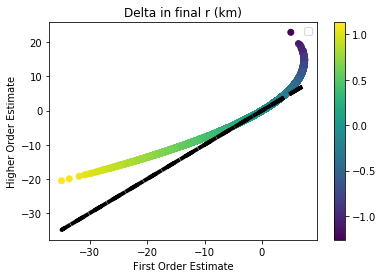

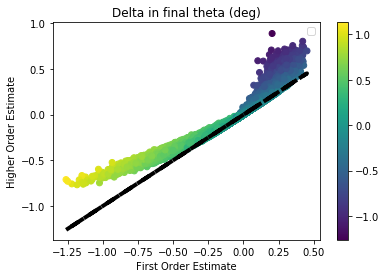

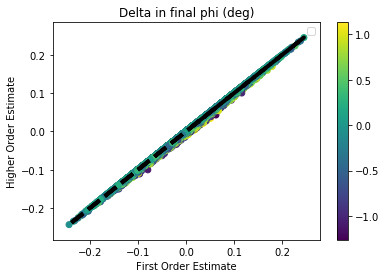

In [898]:
for d, d1, px1, name, scale, unit in zip(dy.T, dy1.T, p1.T,names, [1/1000, 180/np.pi, 180/np.pi], ['km', 'deg','deg']):
    
#     plt.figure()
#     plt.hist([d1*scale, d*scale], bins = 50, histtype='step', label=['First Order', 'Total']) #
#     plt.title(f"Delta in final {name} ({unit})")
#     plt.legend()
    
    plt.figure()
    plt.scatter(d1*scale, d*scale, c=deltas[:,7]) #
    plt.colorbar()
    plt.plot(d1*scale, d1*scale, 'k--', linewidth=4)
    plt.title(f"Delta in final {name} ({unit})")
    plt.xlabel("First Order Estimate")
    plt.ylabel("Higher Order Estimate")
    plt.legend()


plt.show()

In [899]:
def test_update(state, delta):
    from scipy.special import factorial 
    
    sf = dasim.df[state].iloc[-1]
    order = sf.order

#     display(sf)
    sd = sf.constant_cf + delta
    print("Target = {:.2f} ".format(sd))

    # Determine the required control correction by solving the linear and quadratic equations and test them for accuracy 
#     dfdu = sf.partial('u').constant_cf
#     df2 = sf.partial('u').partial('u').constant_cf
    
#     du_linear = delta/dfdu
#     coeff = [0.5*df2, dfdu, -delta]
    coeff = []
    for i in range(1, order+1):
        c = sf.extract_terms(i)
        for j in range(i):
            c = c.partial('u')
        coeff.append(c.constant_cf/factorial(i)) 
        
    coeff = coeff[::-1]
    coeff.append(-delta)
    print(coeff)
    du_linear = delta/coeff[-2]
    du_quad = np.roots(coeff)
    du_quad = du_quad[np.isreal(du_quad)] # keeps just the real roots
    
#     du_quad = du_quad[np.argmin(np.abs(du_quad))]
    print("Linear update = {:.2f}".format(np.degrees(du_linear)))
    print("Order {} updates = {}".format(order, np.degrees(du_quad)))
    
    sim = Simulation(cycle=Cycle(1), output=False, use_da=False, **EntrySim(Vf=Vf), )

    sol = []
    for du in [du_linear, *du_quad]:
        def ref_profile(velocity, **args):
            return np.radians(35)+du

        res = sim.run(x0, [ref_profile])
        sol.append(sim.df)
        print(sim.df[state].iloc[-1])
    return sol 

In [900]:
dfs = test_update('longitude', np.degrees(10/3397))

Target = 8.88 
[-0.43056012970233454, -0.6928557495027592, -0.16866582135143457]
Linear update = -13.95
Order 2 updates = [-75.06944517 -17.13070881]
9.063004031515487
8.542786779459753
9.141244184628533


In [901]:
dfs = test_update('altitude', -3)


Target = -2.91 
[-11.274602695014444, -18.189583577834874, 3]
Linear update = 9.45
Order 2 updates = [-101.07848474    8.64184654]
-2.5622009865283033
-8.303817744712811
-2.3280008051590992


In [902]:
du = dasim.df['altitude'].iloc[-1].subs('dr', 0.).subs('dV', 0).subs('dphi', 0).subs('dfpa', 0).subs('dm', 0)-dasim.df['altitude'].iloc[-1].constant_cf
du.subs('du', np.radians(8.70534037))

-3.02394